In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import os
import cv2

In [ ]:
categories=['CT_COVID','CT_NonCOVID']

In [ ]:
train_dir = '/content/drive/My Drive/Covid_CT/train/'
test_dir = '/content/drive/My Drive/Covid_CT/test/'


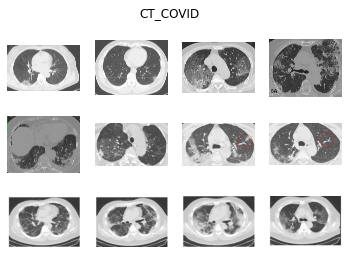

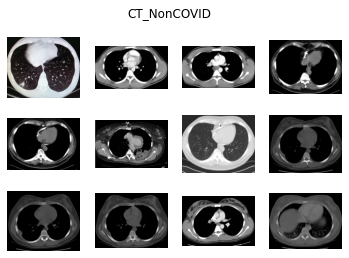

In [ ]:
for category in categories:
  fig, _=plt.subplots(3,4)
  fig.suptitle(category)
  for k, v in enumerate(os.listdir(train_dir+category) [:12]):
    img=plt.imread(train_dir+category+'/'+v)
    plt.subplot(3,4,k+1)
    plt.axis("off")
    plt.imshow(img)
  plt.show()

i am going to split data into  train and test and vaildation part by Imgaegenerators

In [ ]:
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
 
 
LR = 1e-5
height=128
width=128
channels=3
seed=1337
batch_size = 64 #Number of images to load at each iteration
num_classes = 2
epochs = 50
data_augmentation = True
num_predictions = 20
 
# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
 
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    )
 
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical'                                                 
                                                  )
 
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )
 
train_num = train_generator.samples
validation_num = validation_generator.samples


Found 746 images belonging to 2 classes.
Found 438 images belonging to 2 classes.
Found 438 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'CT_COVID': 0, 'CT_NonCOVID': 1}

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(height, width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc', 'Precision', 'Recall'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
activation_7 (Activation)    (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
activation_8 (Activation)    (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 128)      

In [ ]:
filepath=str(os.getcwd()+"/CT_Covid_Noraml_Model_Train1.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.8143 - acc: 0.4901 - precision: 0.4901 - recall: 0.4901
Epoch 00001: val_acc improved from -inf to 0.54688, saving model to /content/CT_Covid_Noraml_Model_Train1.h5f
INFO:tensorflow:Assets written to: /content/CT_Covid_Noraml_Model_Train1.h5f/assets
11/11 [==============================] - 73s 7s/step - loss: 0.8143 - acc: 0.4901 - precision: 0.4901 - recall: 0.4901 - val_loss: 0.6912 - val_acc: 0.5469 - val_precision: 0.5469 - val_recall: 0.5469
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.6836 - acc: 0.5513 - precision: 0.5513 - recall: 0.5513
Epoch 00002: val_acc improved from 0.54688 to 0.60677, saving model to /content/CT_Covid_Noraml_Model_Train1.h5f
INFO:tensorflow:Assets written to: /content/CT_Covid_Noraml_Model_Train1.h5f/assets
11/11 [==============================] - 71s 6s/step - loss: 0.6836 - acc: 0.5513 - precision: 0.5513 - recall: 0.5513 - val_loss: 0.6654 - val_acc: 0.6068 

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics 
%matplotlib inline
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(validation_generator.classes,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
confusion_mtx

array([[172,  23],
       [109, 134]])

In [ ]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.61      0.88      0.72       195
           1       0.85      0.55      0.67       243

    accuracy                           0.70       438
   macro avg       0.73      0.72      0.70       438
weighted avg       0.75      0.70      0.69       438



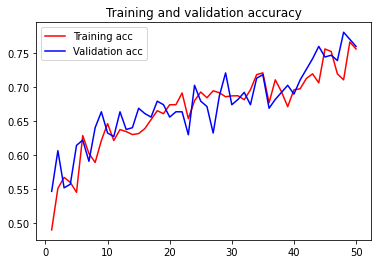

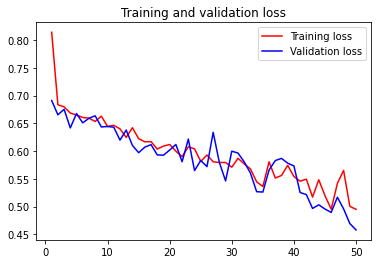

In [ ]:
#Plot Training and validation accuracy and Training and validation loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
import cv2
test_data=[]
test_image_o=cv2.imread('/content/drive/My Drive/Covid_CT/test/CT_NonCOVID/102.png')
test_image=cv2.resize(test_image_o,(height,width))# .flatten()
test_data.append(test_image)

# scale the raw pixel intensities to the range [0, 1]
test_data=np.array(test_image,dtype="float")/255.0
test_data=test_data.reshape([-1,150,150,3])
pred = model_trained.predict_generator(test_data)
predictions =np.argmax(pred, axis=1) # return to label
print ('Prediction : '+categories[predictions[0]])

Prediction : CT_NonCOVID


In [ ]:
path='/content/drive/My Drive/Covid_model_save/CT_Covid_Noraml_Model_Train1.h5f'
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Covid_model_save/CT_Covid_Noraml_Model_Train1.h5f/assets


# Fine Tuned Model

In [ ]:
#import library 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from keras.applications import vgg16
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(width, height, 3), pooling="max")

for layer in model.layers[:-5]: #freeze all layers except the last ten
        layer.trainable = False
#Check the trainable status of the individual layers        
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa62265dc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa62289c6a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa622638b38> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa6225ffe10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa62289c7b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa622674588> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa622530a58> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa6225301d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa6226286d8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa622538cc0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa62253ffd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential

# Although this part can be done also with the functional API, I found that for this simple models, this becomes more intuitive
transfer_model = Sequential()
for layer in model.layers:
    transfer_model.add(layer)
transfer_model.add(Dense(512, activation="relu"))  # Very important to use relu as activation function, search for "vanishing gradiends" :)
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(2, activation="softmax")) # Finally our activation layer! we use 10 outputs as we have 3 covid case(covid normal varial pnemoniea ) (labels)


In [ ]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)

transfer_model.compile(loss="categorical_crossentropy",
                      optimizer=adam,
                      metrics=["accuracy"])

In [ ]:
learning_rate = 5e-5

checkpoint = ModelCheckpoint("CT_Covid_VGG.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [ ]:
model_history = transfer_model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=50,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                             callbacks=[checkpoint], 
                              verbose = 1)


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.8649 - acc: 0.5337 
Epoch 00001: val_acc improved from -inf to 0.61979, saving model to CT_Covid_VGG.h5
11/11 [==============================] - 191s 17s/step - loss: 0.8649 - acc: 0.5337 - val_loss: 0.6504 - val_acc: 0.6198
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.7118 - acc: 0.5850 
Epoch 00002: val_acc improved from 0.61979 to 0.65104, saving model to CT_Covid_VGG.h5
11/11 [==============================] - 194s 18s/step - loss: 0.7118 - acc: 0.5850 - val_loss: 0.5895 - val_acc: 0.6510
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.6114 - acc: 0.6569 
Epoch 00003: val_acc improved from 0.65104 to 0.73958, saving model to CT_Covid_VGG.h5
11/11 [==============================] - 190s 17s/step - loss: 0.6114 - acc: 0.6569 - val_loss: 0.5667 - val_acc: 0.7396
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 0.5672 - acc: 0.7199 
Epoch 00004: val_ac

In [ ]:
path='/content/drive/My Drive/Covid_model_save/VGG16Model_CT_Scan_Covid.h5'
model.save(path)

In [ ]:
for metric in model_history.history.keys():
    print(metric)

loss
acc
val_loss
val_acc


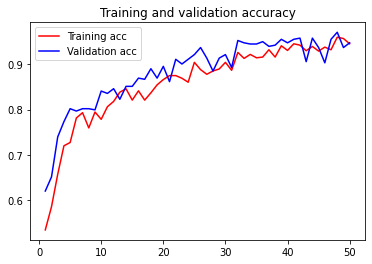

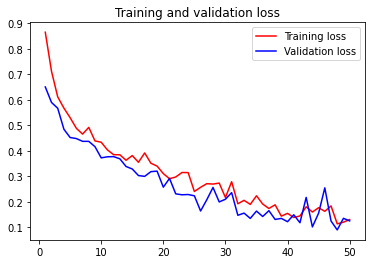

In [ ]:
#Plot Training and validation accuracy and Training and validation loss
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred = transfer_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

Instructions for updating:
Please use Model.predict, which supports generators.


array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 98.2% 


In [ ]:
print(metrics.classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       195
           1       0.98      0.99      0.98       243

    accuracy                           0.98       438
   macro avg       0.98      0.98      0.98       438
weighted avg       0.98      0.98      0.98       438



In [ ]:
import cv2
test_data=[]
test_image_o=cv2.imread('/content/drive/My Drive/Covid_CT/Covid_Image1.jpg')
test_image=cv2.resize(test_image_o,(height,width))# .flatten()
test_data.append(test_image)

# scale the raw pixel intensities to the range [0, 1]
test_data=np.array(test_image,dtype="float")/255.0
test_data=test_data.reshape([-1,128,128,3])
pred = transfer_model.predict_generator(test_data)
predictions =np.argmax(pred, axis=1) # return to label
print ('Prediction : '+categories[predictions[0]])

Prediction : CT_NonCOVID


In [ ]:
transfer_model.evaluate(test_generator)

7/7 [==============================] - 62s 9s/step - loss: 0.0483 - acc: 0.9817


[0.048313066363334656, 0.9817351698875427]